In [1]:
import pandas as pd
import numpy as np
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.base import clone
import matplotlib.pyplot as plt 

In [2]:
def gen_data():
    # Parameters
    n = 1000  # Number of individuals
    p = 50    # Number of covariates

    # Generate covariates for period 1
    x1 = np.random.randn(n, p)
    
    # Generate treatment which is binary and depends on a linear combination of x1 with a cutoff
    linear_combination = np.dot(x1, np.random.randn(p))
    d = (linear_combination + np.random.randn(n) > linear_combination.mean()).astype(int)

    # Generate covariates for period 2, dependent on x1 and d
    x2 = x1 + np.random.randn(n, p) +  np.outer(d, np.random.randn(p))
    
    # Generate errors which are independent
    e1 = np.random.randn(n)
    e2 = np.random.randn(n)

    # Define true function g and h
    def g(x, d):
        return np.dot(x, np.random.randn(p))

    def h(x, t):
        return np.dot(x, np.random.randn(p))

    # Treatment effect
    beta = 2.0

    # Generate outcomes
    y1 = h(x1, 1) + g(x1, d) + d +   e1
    y2 = beta *d*1 + g(x2, d) + d + 1 +  e2

    # Combine into a dataframe
    data_period1 = pd.DataFrame(x1, columns=[f'x{i+1}' for i in range(p)])
    data_period1['y'] = y1
    data_period1['d'] = d
    data_period1['t'] = 1

    data_period2 = pd.DataFrame(x2, columns=[f'x{i+1}' for i in range(p)])
    data_period2['y'] = y2
    data_period2['d'] = d
    data_period2['t'] = 2

    data = pd.concat([data_period1, data_period2], ignore_index=True)
    
    return data

# Generate the data
data = gen_data()

print(data[['d','t']].describe())
print(data[['d','t']][data['t']==1].describe())
print(data[['d','t']][data['t']==2].describe())

                 d            t
count  2000.000000  2000.000000
mean      0.491000     1.500000
std       0.500044     0.500125
min       0.000000     1.000000
25%       0.000000     1.000000
50%       0.000000     1.500000
75%       1.000000     2.000000
max       1.000000     2.000000
                 d       t
count  1000.000000  1000.0
mean      0.491000     1.0
std       0.500169     0.0
min       0.000000     1.0
25%       0.000000     1.0
50%       0.000000     1.0
75%       1.000000     1.0
max       1.000000     1.0
                 d       t
count  1000.000000  1000.0
mean      0.491000     2.0
std       0.500169     0.0
min       0.000000     2.0
25%       0.000000     2.0
50%       0.000000     2.0
75%       1.000000     2.0
max       1.000000     2.0


In [3]:
def regular_estimate(data):
    # Define outcome, treatment, and covariates
    
    n = data.shape[0]
    p = data.shape[1] -3
    
    y = data['y']
    d = data['d']
    t = data['t']

    # Define d*(t==2)
    dt = (d * (t == 2)).astype(float)
    dt.name = 'dt'  # properly name the series

    x = data[[f'x{i+1}' for i in range(p)]].copy()
    # Double Machine Learning
    #learner = RandomForestRegressor(n_estimators=20)#n_estimators=50)#, max_features=10, max_depth=5, min_samples_leaf=5)
    learner = Lasso()
    ml_m = clone(learner)
    ml_l = clone(learner)

    #Note: ml_l.fit(x, y) ... ml_m.fit(x, d)
    dml_data = dml.DoubleMLData(pd.concat([x.copy(), dt.copy(), y.copy()], axis=1), y_col='y', d_cols='dt')
    dml_plr = dml.DoubleMLPLR(dml_data,  ml_m=ml_m, ml_l=ml_l)
    dml_plr.fit()
    return dml_plr.coef[0]


def estimate_plus_dt(data):
    # Define outcome, treatment, and covariates
    
    n = data.shape[0]
    p = data.shape[1] -3
    
    y = data['y']
    d = data['d']
    t = data['t']

    # Define d*(t==2)
    dt = (d * (t == 2)).astype(float)
    dt.name = 'dt'  # properly name the series

    x = data[[f'x{i+1}' for i in range(p)]+['d','t']].copy()
    x['t'] = x['t'] - 1
    # Double Machine Learning
    #learner = RandomForestRegressor(n_estimators=20)#n_estimators=50)#, max_features=10, max_depth=5, min_samples_leaf=5)
    learner = Lasso()
    ml_m = clone(learner)
    ml_l = clone(learner)

    #Note: ml_l.fit(x, y) ... ml_m.fit(x, d)
    dml_data = dml.DoubleMLData(pd.concat([x.copy(), dt.copy(), y.copy()], axis=1), y_col='y', d_cols='dt')
    dml_plr = dml.DoubleMLPLR(dml_data,  ml_m=ml_m, ml_l=ml_l)
    dml_plr.fit()
    return dml_plr.coef[0]


def demean(y_name,x_name,data=None,absorb=None,cluster=None): 
    y,X = data[ y_name], data[ x_name ]
    
    y_dot = y.copy()
    X_dot = X.copy()
    
    ybar = y.mean()
    Xbar = X.mean()

    for effect in absorb:
        y_dot = y_dot - y.groupby(data[effect]).transform('mean')
        X_dot = X_dot - X.groupby(data[effect]).transform('mean')
    y_dot = y_dot + ybar
    X_dot = X_dot + Xbar
    return y_dot, X_dot
#TODO within transformation


def estimate_demaned(data):
    # Define outcome, treatment, and covariates
    
    n = data.shape[0]
    p = data.shape[1] -3
    
    d = data['d']
    t = data['t']

    # Define d*(t==2)
    dt = (d * (t == 2)).astype(float)
    dt.name = 'dt'  # properly name the series

    y,x = demean(['y'],[f'x{i+1}' for i in range(p)],data=data,absorb=['t','d'])
 
    # Double Machine Learning
    #learner = RandomForestRegressor(n_estimators=20)#n_estimators=50)#, max_features=10, max_depth=5, min_samples_leaf=5)
    learner = Lasso()
    ml_m = clone(learner)
    ml_l = clone(learner)

    #Note: ml_l.fit(x, y) ... ml_m.fit(x, d)
    dml_data = dml.DoubleMLData(pd.concat([x.copy(), dt.copy(), y.copy()], axis=1), y_col='y', d_cols='dt')
    dml_plr = dml.DoubleMLPLR(dml_data,  ml_m=ml_m, ml_l=ml_l)
    dml_plr.fit()
    return dml_plr.coef[0]



# Initialize result lists
regular_results = []
demeaned_results = []
plus_dt_results = []

# Loop to generate data and compute estimates
for i in range(1000):
    data = gen_data()
    
    # Obtain estimates from the different methods
    regular_coef = regular_estimate(data) 
    plus_dt_coef = estimate_plus_dt(data)
    demeaned_coef = estimate_demaned(data)
    
    # Store the results in respective lists
    regular_results.append(regular_coef)
    plus_dt_results.append(plus_dt_coef)
    demeaned_results.append(demeaned_coef)

Double ML Results: Mean = 0.821123971873831, Std Dev = 1.4369470783853249
Demeaned Results: Mean = 0.3352729404026911, Std Dev = 1.0958834183155495
Plus DT Results: Mean = 0.8214484115023142, Std Dev = 1.4366547459587993


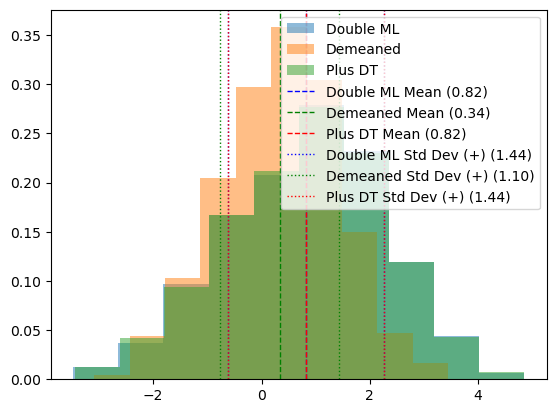

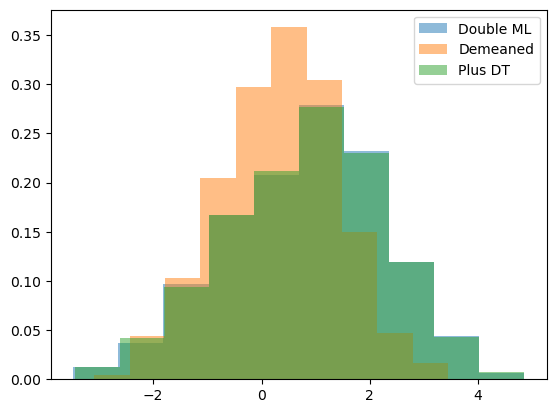

In [4]:
# Calculate means and standard deviations
mean_regular_results = np.mean(regular_results)
std_regular_results = np.std(regular_results)

mean_demeaned_results = np.mean(demeaned_results)
std_demeaned_results = np.std(demeaned_results)

mean_plus_dt_results = np.mean(plus_dt_results)
std_plus_dt_results = np.std(plus_dt_results)

# Print the mean and standard deviation values
print(f"Double ML Results: Mean = {mean_regular_results}, Std Dev = {std_regular_results}")
print(f"Demeaned Results: Mean = {mean_demeaned_results}, Std Dev = {std_demeaned_results}")
print(f"Plus DT Results: Mean = {mean_plus_dt_results}, Std Dev = {std_plus_dt_results}")

# Plot the histograms
plt.hist(regular_results, label='Double ML', density=True, alpha=0.5)
plt.hist(demeaned_results, label='Demeaned', density=True, alpha=0.5)
plt.hist(plus_dt_results, label='Plus DT', density=True, alpha=0.5)

# Plot the means
plt.axvline(mean_regular_results, color='blue', linestyle='dashed', linewidth=1, label=f'Double ML Mean ({mean_regular_results:.2f})')
plt.axvline(mean_demeaned_results, color='green', linestyle='dashed', linewidth=1, label=f'Demeaned Mean ({mean_demeaned_results:.2f})')
plt.axvline(mean_plus_dt_results, color='red', linestyle='dashed', linewidth=1, label=f'Plus DT Mean ({mean_plus_dt_results:.2f})')

# Plot the standard deviations
plt.axvline(mean_regular_results + std_regular_results, color='blue', linestyle='dotted', linewidth=1, label=f'Double ML Std Dev (+) ({std_regular_results:.2f})')
plt.axvline(mean_regular_results - std_regular_results, color='blue', linestyle='dotted', linewidth=1)

plt.axvline(mean_demeaned_results + std_demeaned_results, color='green', linestyle='dotted', linewidth=1, label=f'Demeaned Std Dev (+) ({std_demeaned_results:.2f})')
plt.axvline(mean_demeaned_results - std_demeaned_results, color='green', linestyle='dotted', linewidth=1)

plt.axvline(mean_plus_dt_results + std_plus_dt_results, color='red', linestyle='dotted', linewidth=1, label=f'Plus DT Std Dev (+) ({std_plus_dt_results:.2f})')
plt.axvline(mean_plus_dt_results - std_plus_dt_results, color='red', linestyle='dotted', linewidth=1)

# Adding legend
plt.legend()
plt.show()

# Alternatively, if you want separate plots for clarity:

plt.hist(regular_results, label='Double ML', density=True, alpha=0.5)
plt.hist(demeaned_results, label='Demeaned', density=True, alpha=0.5)
plt.hist(plus_dt_results, label='Plus DT', density=True, alpha=0.5)
plt.legend()
plt.show()